In [1]:
# load required libraries
options(stringsAsFactors = F)
suppressPackageStartupMessages({
# single-cell analysis package
library(Seurat)

# plotting and data science packages
library(tidyverse)
library(cowplot)
library(patchwork)
library(devtools)
library(igraph)

# co-expression network analysis packages:
library(WGCNA)
# devtools::install_github('smorabit/hdWGCNA', ref='dev')
library(hdWGCNA)

# using the cowplot theme for ggplot
theme_set(theme_cowplot())
})
# set random seed for reproducibility
set.seed(123)

Warning message in system("timedatectl", intern = TRUE):
“running command 'timedatectl' had status 1”


In [2]:
# load the human TE sample
sample_score <- readRDS("sample_mouse_TE_EHT.rds")
sample_score

An object of class Seurat 
51023 features across 5103 samples within 2 assays 
Active assay: SCT (17451 features, 3000 variable features)
 1 other assay present: RNA
 3 dimensional reductions calculated: pca, tsne, umap

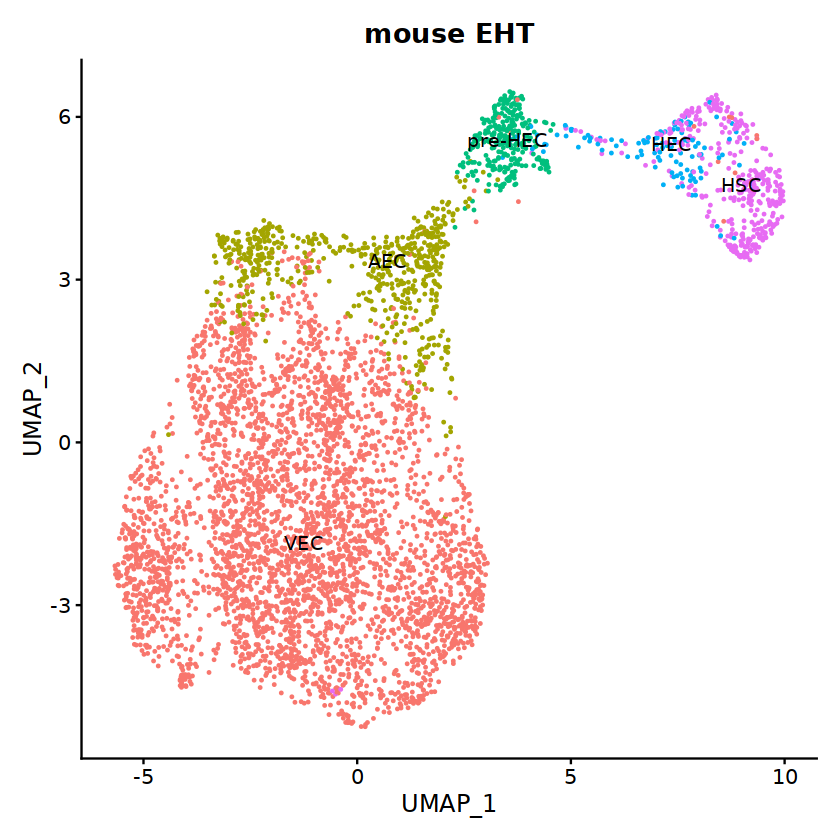

In [3]:
# umap
DimPlot(sample_score, reduction = "umap", group.by='celltype', label=TRUE) + ggtitle('mouse EHT') + NoLegend()

In [4]:
# extract celltype marker gene and TE
feature_good <- rownames(sample_score@assays$RNA@counts[which(rowSums(sample_score@assays$RNA@counts) >= 50), ])
TE_genes <- grep(feature_good, pattern = "\\.DNA|\\.SINE|\\.LINE|\\.LTR", value = T)
length(TE_genes)

celltype_marker_genes <- read.csv("meta/celltype_markers_MAST_mouse.csv", row.names = 1)
celltype_marker_genes <- subset(celltype_marker_genes, p_val_adj <= 0.05 & avg_log2FC >= 0.5)
celltype_marker_genes <- intersect(feature_good, celltype_marker_genes$gene)
length(celltype_marker_genes)

[1] 864

[1] 421

In [5]:
# setup for hdWGCNA
sample <- SetupForWGCNA(
  sample_score,
  features = c(celltype_marker_genes, TE_genes), # the gene selection approach
  wgcna_name = "EHT" # the name of the hdWGCNA experiment
)
length(sample@misc$EHT$wgcna_genes)

[1] 1285

In [6]:
# construct metacells  in each group
sample <- MetacellsByGroups(
  seurat_obj = sample,
  group.by = c("celltype", "orig.ident"), # specify the columns in seurat_obj@meta.data to group by
  ident.group = 'celltype', # set the Idents of the metacell seurat object
  k = 25, # nearest-neighbors parameter
  reduction = "pca",
  assay = "RNA",
  slot = 'counts',
  max_shared = 10 # maximum number of shared cells between two metacells
)

# normalize metacell expression matrix:
sample <- NormalizeMetacells(sample)

# get the metacell object from the hdWGCNA experiment
metacell_obj <- GetMetacellObject(sample)
metacell_obj

Warning message in MetacellsByGroups(seurat_obj = sample, group.by = c("celltype", :
“Removing the following groups that did not meet min_cells: HEC#E105EndoLib24, HEC#E105EndoWT, HEC#E115PLUS, HSC#E105EndoLib24, HSC#E105EndoWT, VEC#E115PLUS, pre-HEC#E105EndoWT”


An object of class Seurat 
33572 features across 1579 samples within 1 assay 
Active assay: RNA (33572 features, 0 variable features)

In [7]:
# extract interested clusters
sample <- SetDatExpr(
  sample,
  group_name = c("VEC","AEC","pre-HEC","HSC"), # the name of the group of interest in the group.by column
  group.by='celltype', # the metadata column containing the cell type info. This same column should have also been used in MetacellsByGroups
  assay = 'RNA', # using SCT assay
  use_metacells = TRUE, # use the metacells (TRUE) or the full expression matrix (FALSE)
  slot = 'data' # using normalized data
)

pickSoftThreshold: will use block size 1285.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 1285 of 1285


Warning message:
“executing %dopar% sequentially: no parallel backend registered”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'x'. Pearson correlation was used for individual columns with zero (or missing) MAD.”
Warning message in (function (x, y = NULL, robustX = TRUE, robustY = TRUE, use = "all.obs", :
“bicor: zero MAD in variable 'y'. Pearson correlation was used for individual columns with zero (or missing) MAD.”


   Power SFT.R.sq  slope truncated.R.sq mean.k. median.k. max.k.
1      1   0.6470  5.770          0.886  706.00  7.03e+02  833.0
2      2   0.1800  1.120          0.780  402.00  3.89e+02  574.0
3      3   0.0619 -0.392          0.584  236.00  2.18e+02  417.0
4      4   0.4910 -1.030          0.573  144.00  1.25e+02  317.0
5      5   0.8320 -1.360          0.799   91.10  7.25e+01  250.0
6      6   0.9160 -1.470          0.895   59.90  4.43e+01  203.0
7      7   0.9380 -1.420          0.940   40.90  2.68e+01  170.0
8      8   0.9410 -1.370          0.939   29.10  1.63e+01  145.0
9      9   0.9540 -1.310          0.958   21.40  9.95e+00  126.0
10    10   0.9500 -1.280          0.951   16.30  6.29e+00  111.0
11    12   0.9530 -1.200          0.949   10.30  2.64e+00   90.1
12    14   0.9620 -1.140          0.953    7.11  1.18e+00   75.3
13    16   0.9860 -1.120          0.983    5.23  5.32e-01   64.5
14    18   0.9620 -1.090          0.954    4.03  2.52e-01   56.2
15    20   0.9500 -1.070 

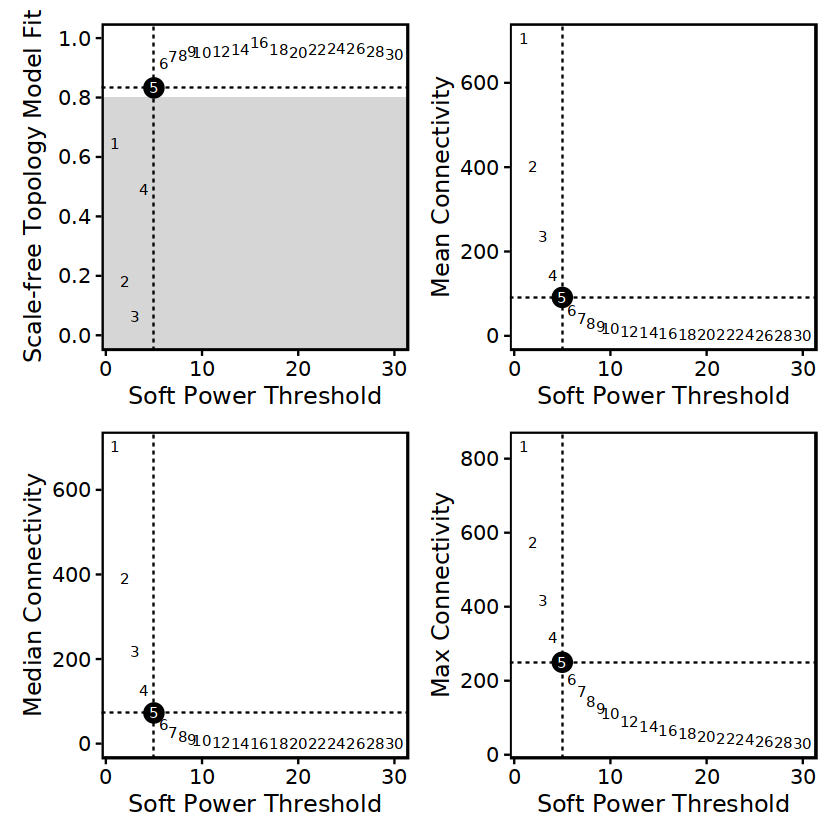

In [8]:
# Test different soft powers:
sample <- TestSoftPowers(
  sample,
  networkType = 'signed',
  setDatExpr=FALSE,
  powers = c(seq(1, 10, by = 1), seq(12, 30, by = 2)))

# plot the results:
plot_list <- PlotSoftPowers(sample, point_size = 5, text_size = 3)
# assemble with patchwork
wrap_plots(plot_list, ncol=2)

Warning message in ConstructNetwork(sample, soft_power = 5, setDatExpr = FALSE, :
“Overwriting TOM TOM/EHT_TOM.rda”


 Calculating consensus modules and module eigengenes block-wise from all genes
 Calculating topological overlaps block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
    TOM calculation: adjacency..
    ..will not use multithreading.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
 ..Working on block 1 .
 ..Working on block 1 .
 ..merging consensus modules that are too close..


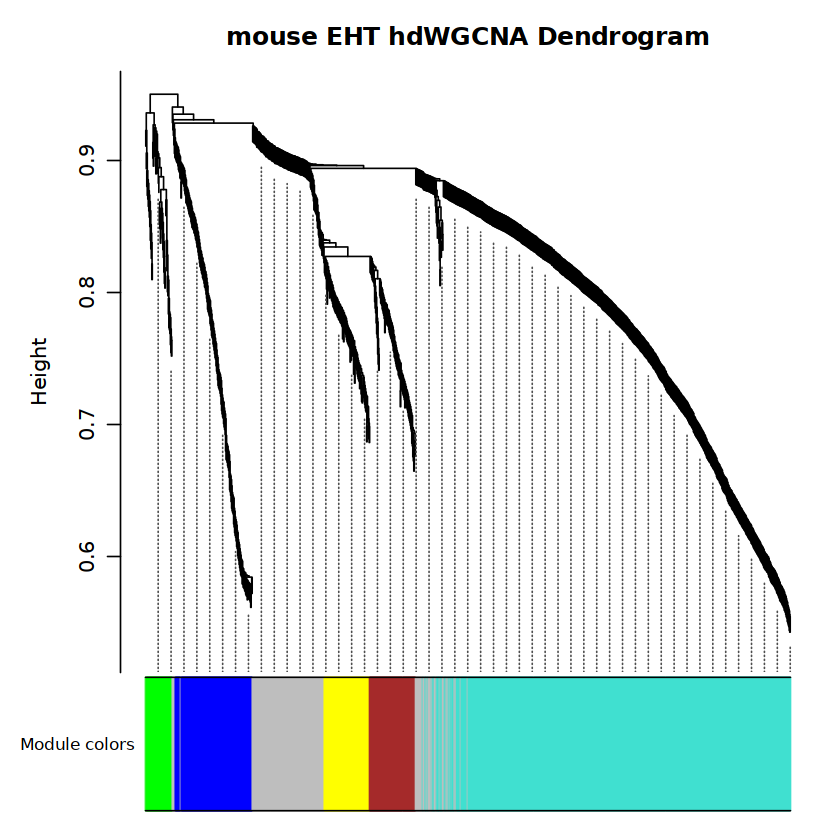

In [9]:
# calculate TOM matrix and cluster genes
sample <- ConstructNetwork(
  sample, 
  soft_power=5,
  setDatExpr=FALSE,
  corType = "pearson",
  networkType = "signed",
  TOMType = "signed",
  detectCutHeight = 0.995,
  minModuleSize = 30,
  mergeCutHeight = 0.2,
  tom_outdir = "TOM",
  overwrite_tom = T,
  tom_name = 'EHT' # name of the topoligical overlap matrix written to disk
)
PlotDendrogram(sample, main='mouse EHT hdWGCNA Dendrogram')

In [10]:
# need to run ScaleData first or else harmony throws an error:
sample <- ScaleData(sample, features=VariableFeatures(sample))
# compute all MEs in the full single-cell dataset
sample <- ModuleEigengenes(
  sample,
  scale.model.use = "linear", #  choices are "linear", "poisson", or "negbinom"
  pc_dim = 1,
  group.by.vars="orig.ident",
  verbose = FALSE
)

Centering and scaling data matrix



[1] "yellow"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clustersRNA_snn_res.0.6celltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1DeuhAT.Tip100AluB2B4ERVKhAT.BlackjackCR1hAT.CharlieTcMarERVLDNAL1ERV1IDTcMar.Tc2L2RTE.XtRNAGypsyLTRPiggyBacTcMar.MarinerTcMar.TiggerSINETcMar.PogohATMIRERVL.MaLRDong.R4MULE.MuDRMuDRPenelopeRTE.BovBI.JockeyhAT.ActRNA.RTEX5S.Deu.L2tRNA.DeuhAT.Tag1TcMar.Tc1MerlinPIF.HarbingerKolobokCryptonCrypton.Ametacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcayellow to pcayellow_”
Warning message:
“All keys should be one or more alphanum

[1] "blue"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clustersRNA_snn_res.0.6celltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1DeuhAT.Tip100AluB2B4ERVKhAT.BlackjackCR1hAT.CharlieTcMarERVLDNAL1ERV1IDTcMar.Tc2L2RTE.XtRNAGypsyLTRPiggyBacTcMar.MarinerTcMar.TiggerSINETcMar.PogohATMIRERVL.MaLRDong.R4MULE.MuDRMuDRPenelopeRTE.BovBI.JockeyhAT.ActRNA.RTEX5S.Deu.L2tRNA.DeuhAT.Tag1TcMar.Tc1MerlinPIF.HarbingerKolobokCryptonCrypton.Ametacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcablue to pcablue_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcablue_”
Warning message:
“Cannot add objects with duplicate keys (offending key: harmony_), setti

[1] "grey"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clustersRNA_snn_res.0.6celltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1DeuhAT.Tip100AluB2B4ERVKhAT.BlackjackCR1hAT.CharlieTcMarERVLDNAL1ERV1IDTcMar.Tc2L2RTE.XtRNAGypsyLTRPiggyBacTcMar.MarinerTcMar.TiggerSINETcMar.PogohATMIRERVL.MaLRDong.R4MULE.MuDRMuDRPenelopeRTE.BovBI.JockeyhAT.ActRNA.RTEX5S.Deu.L2tRNA.DeuhAT.Tag1TcMar.Tc1MerlinPIF.HarbingerKolobokCryptonCrypton.Ametacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcagrey to pcagrey_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcagrey_”
Warning message:
“Invalid name supplied, making object name syntactically valid. New obje

[1] "brown"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clustersRNA_snn_res.0.6celltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1DeuhAT.Tip100AluB2B4ERVKhAT.BlackjackCR1hAT.CharlieTcMarERVLDNAL1ERV1IDTcMar.Tc2L2RTE.XtRNAGypsyLTRPiggyBacTcMar.MarinerTcMar.TiggerSINETcMar.PogohATMIRERVL.MaLRDong.R4MULE.MuDRMuDRPenelopeRTE.BovBI.JockeyhAT.ActRNA.RTEX5S.Deu.L2tRNA.DeuhAT.Tag1TcMar.Tc1MerlinPIF.HarbingerKolobokCryptonCrypton.Ametacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcabrown to pcabrown_”
Warning message:
“All keys should be one or more alphanumer

[1] "turquoise"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clustersRNA_snn_res.0.6celltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1DeuhAT.Tip100AluB2B4ERVKhAT.BlackjackCR1hAT.CharlieTcMarERVLDNAL1ERV1IDTcMar.Tc2L2RTE.XtRNAGypsyLTRPiggyBacTcMar.MarinerTcMar.TiggerSINETcMar.PogohATMIRERVL.MaLRDong.R4MULE.MuDRMuDRPenelopeRTE.BovBI.JockeyhAT.ActRNA.RTEX5S.Deu.L2tRNA.DeuhAT.Tag1TcMar.Tc1MerlinPIF.HarbingerKolobokCryptonCrypton.Ametacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from pcaturquoise to pcaturquoise_”
Warning message:
“All keys should be one or more alphanumeric characters followed by an underscore '_', setting key to pcaturquoise_”
Warning message:
“Invalid name supplied, making object name syntactically 

[1] "green"


Warning message:
“Invalid name supplied, making object name syntactically valid. New object name is orig.identnCount_RNAnFeature_RNApercent.mtRNA_snn_res.0.5seurat_clustersRNA_snn_res.0.6celltypenCount_SCTnFeature_SCTSCT_snn_res.0.5SCT_snn_res.1DeuhAT.Tip100AluB2B4ERVKhAT.BlackjackCR1hAT.CharlieTcMarERVLDNAL1ERV1IDTcMar.Tc2L2RTE.XtRNAGypsyLTRPiggyBacTcMar.MarinerTcMar.TiggerSINETcMar.PogohATMIRERVL.MaLRDong.R4MULE.MuDRMuDRPenelopeRTE.BovBI.JockeyhAT.ActRNA.RTEX5S.Deu.L2tRNA.DeuhAT.Tag1TcMar.Tc1MerlinPIF.HarbingerKolobokCryptonCrypton.Ametacell_grouping; see ?make.names for more details on syntax validity”
Centering and scaling data matrix

Warning message in irlba(A = t(x = object), nv = npcs, ...):
“You're computing too large a percentage of total singular values, use a standard svd instead.”
Warning message in irlba(A = t(x = object), nv = npcs, ...):
“did not converge--results might be invalid!; try increasing work or maxit”
Warning message:
“Keys should be one or more alphanumeric 

In [11]:
# compute eigengene-based connectivity (kME):
sample <- ModuleConnectivity(
  sample,
  group.by = 'celltype', 
  harmonized = TRUE,
  corFnc = "bicor", # to obtain Pearson correlation
  corOptions = "use='p'", # to obtain Pearson correlation
  assay = NULL,
  slot = "data", # default to normalized 'data' slot
  group_name = c("VEC","AEC","pre-HEC","HSC")
)

# rename the modules
# sample <- ResetModuleNames(
#   sample,
#   new_name = "pre-HEC-"
# )

# print out the new module names
modules <- GetModules(sample)
print(levels(modules$module))

# show the first 6 columns:
head(modules[,1:6])

[1] "yellow"    "blue"      "grey"      "brown"     "turquoise" "green"    


,gene_name,module,color,kME_yellow,kME_blue,kME_grey
,<chr>,<fct>,<chr>,<dbl>,<dbl>,<dbl>
Sox17,Sox17,yellow,yellow,0.47078579,-0.22711729,0.21627634
Prex2,Prex2,yellow,yellow,0.41014524,-0.20679906,0.06764358
Ptpn18,Ptpn18,blue,blue,-0.06073708,0.49919630,-0.17241521
Neurl3,Neurl3,blue,blue,-0.13980847,0.61830375,-0.20257936
Col5a2,Col5a2,grey,grey,0.17541139,-0.08446431,0.01316852
Cavin2,Cavin2,brown,brown,0.35860112,0.01088013,-0.15929171


In [12]:
# get hub genes
hub_df <- GetHubGenes(sample, n_hubs = 10)
head(hub_df)

,gene_name,module,kME
,<chr>,<fct>,<dbl>
1,Sparcl1,yellow,0.5567084
2,Prnd,yellow,0.5700297
3,Nrp1,yellow,0.5725820
4,Col4a1,yellow,0.5728339
5,Unc5b,yellow,0.5957648
6,Igfbp3,yellow,0.6196413


In [13]:
# compute gene scoring for the top 25 hub genes by kME for each module
# with Seurat method
sample <- ModuleExprScore(
  sample,
  n_genes = 25,
  method='Seurat'
)

Selecting by kME_yellow
Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_turquoise
Selecting by kME_green


[1] "yellow"
[1] "blue"
[1] "brown"
[1] "turquoise"
[1] "green"



   yellow      blue      grey     brown turquoise     green 
       91       154       206        91       692        51 

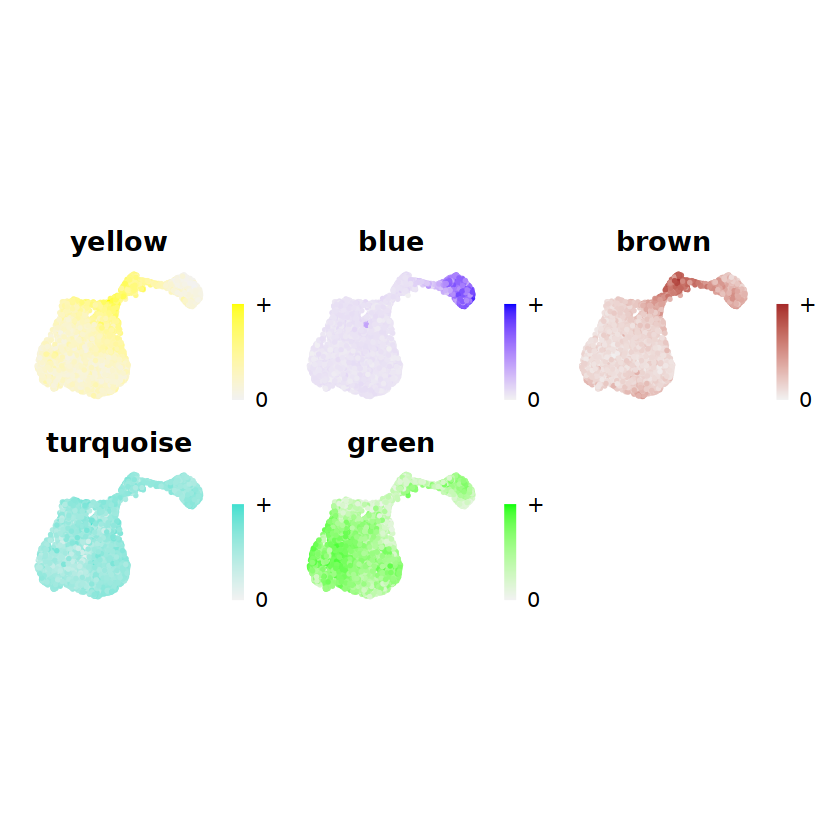

In [14]:
# make a featureplot of hub scores for each module
plot_list <- ModuleFeaturePlot(
  sample,
  features='scores', # plot the hub gene scores
  order='shuffle', # order so cells are shuffled
  ucell = T # depending on Seurat vs UCell for gene scoring
)

# stitch together with patchwork
wrap_plots(plot_list, ncol=3)
table(sample@misc$EHT$wgcna_modules$module)

In [15]:
# get hMEs from seurat object
MEs <- GetMEs(sample, harmonized=TRUE)
mods <- colnames(MEs); mods <- mods[mods != 'grey']

# add hMEs to Seurat meta-data:
sample@meta.data <- cbind(sample@meta.data, MEs)

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.


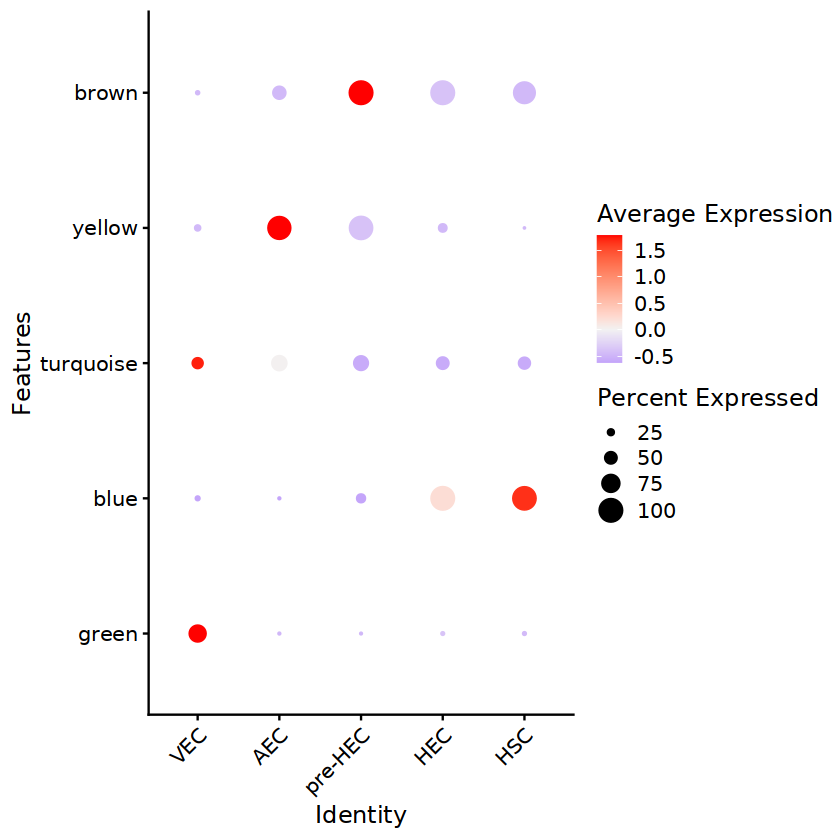

In [16]:
# plot with Seurat's DotPlot function
DotPlot(sample, features=mods, group.by = 'celltype') + coord_flip() + RotatedAxis() + scale_color_gradient2(high='red', mid='grey95', low='blue')

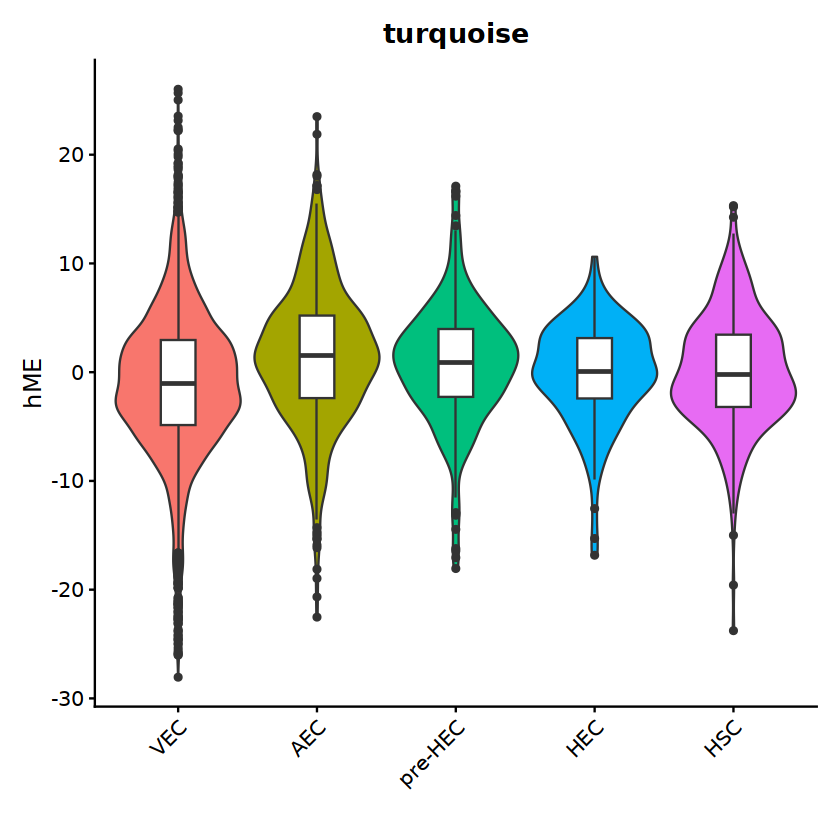

In [17]:
# Plot turquoise hME using Seurat VlnPlot function
p <- VlnPlot(
  sample,
  features = 'turquoise',
  group.by = 'celltype',
  pt.size = 0 # don't show actual data points
)

# add box-and-whisker plots on top:
p <- p + geom_boxplot(width=.25, fill='white')

# change axis labels and remove legend:
p <- p + xlab('') + ylab('hME') + NoLegend()

# plot output
p

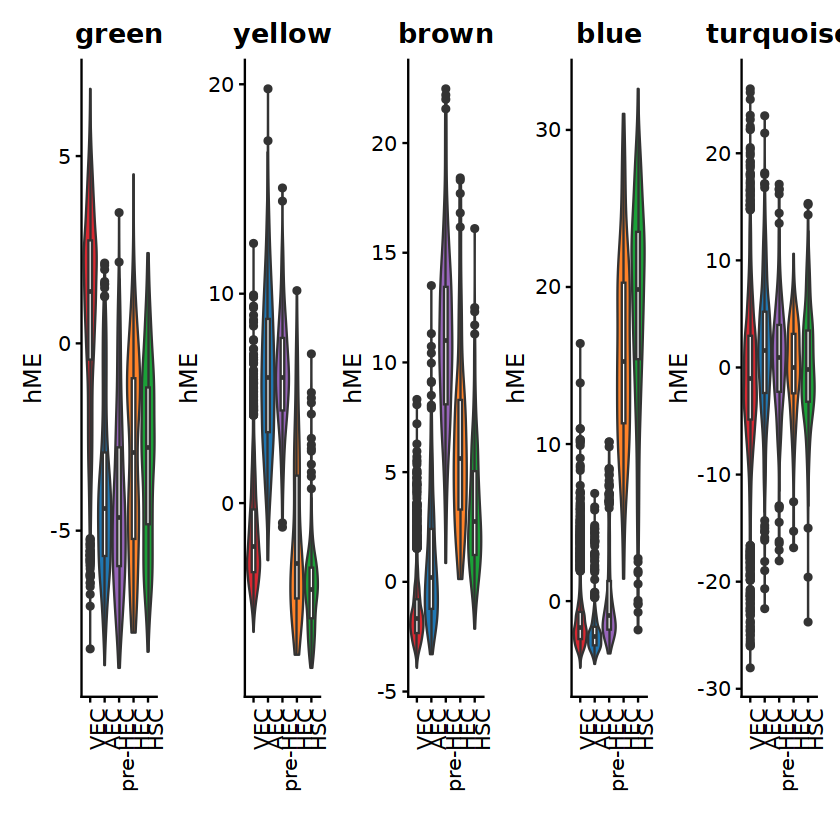

In [18]:
# Plot all hME using Seurat VlnPlot function
mods_vlnplot <- c('green','yellow','brown','blue','turquoise')
plot_list <- lapply(mods_vlnplot, function(x) {
  p <- VlnPlot(
    sample,
    features = x,
    cols = c("#D82831", "#2077B2", "#9765BA", "#FF8228", "#1BA138"),
    group.by = 'celltype',
    pt.size = 0 # don't show actual data points
  )
  
  # add box-and-whisker plots on top:
  p <- p + geom_boxplot(width=.25, fill='white')
  
  # change axis labels and remove legend:
  p <- p + xlab('') + ylab('hME') + NoLegend() + theme(axis.text.x=element_text(angle=90, hjust=1))
  
  p
})
wrap_plots(plot_list, ncol = 5)
ggsave("figure/vlnplot_hME_celltype_mouse.pdf", width = 15, height = 3.8)

In [19]:
library(igraph)
# Visualizes the top hub genes for selected modules as a circular network plot
ModuleNetworkPlot(
  sample,
  mods = "all", # all modules are plotted.
  outdir = "ModuleNetworks", # The directory where the plots will be stored.
  plot_size = c(6, 6),
  label_center = FALSE,
  edge.alpha = 0.25,
  vertex.label.cex = 1,
  vertex.size = 6
)

Writing output files to ModuleNetworks

Selecting by kME_yellow
Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_turquoise
Selecting by kME_green


[1] "yellow"
[1] "blue"
[1] "brown"
[1] "turquoise"
[1] "green"


Selecting by kME_yellow
Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_turquoise
Selecting by kME_green



   yellow      blue      grey     brown turquoise     green 
        8         9         6         9         9         8 
[1] "yellow"    "grey90"    "blue"      "brown"     "turquoise" "green"    
[1] "here"
[1] 446   4


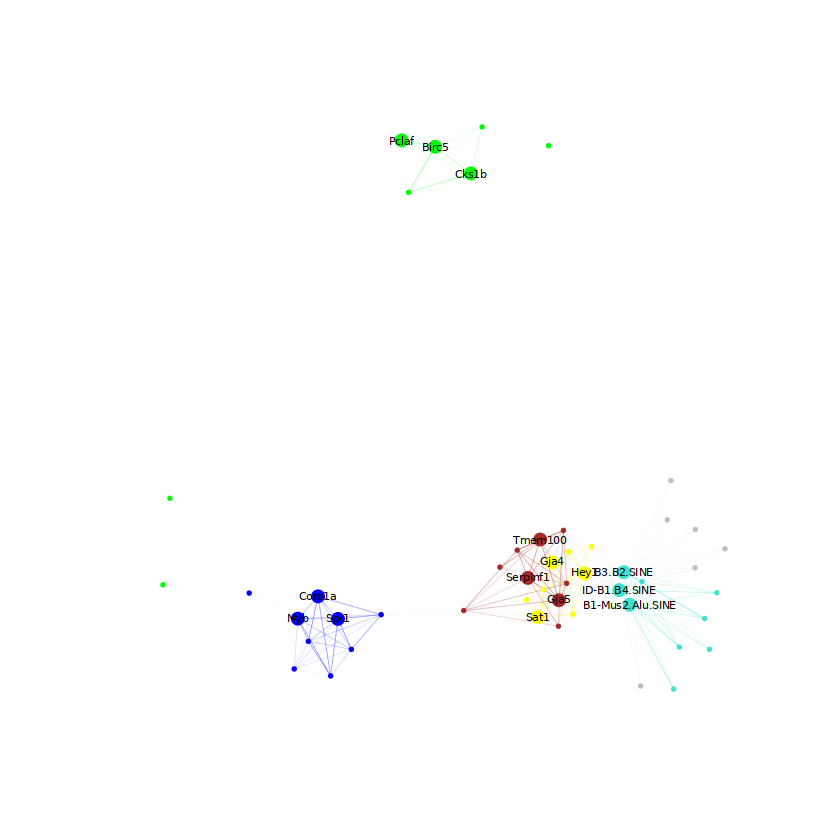

In [20]:
# hubgene network
HubGeneNetworkPlot(
  sample,
  mods = "all", # all modules are plotted.
  n_hubs = 3, 
  n_other=6,
  edge_prop = 0.75,
)

In [21]:
sample <- RunModuleUMAP(
  sample,
  n_hubs = 10, # number of hub genes to include for the UMAP embedding
  n_neighbors=25, # neighbors parameter for UMAP
  min_dist=0.3 # min distance between points in UMAP space
)

Selecting by kME_yellow
Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_turquoise
Selecting by kME_green


In [22]:
# get the hub gene UMAP table from the seurat object
umap_df <- GetModuleUMAP(sample)
umap_df$color_human <- umap_df$color
umap_df$color_human[umap_df$color_human == "yellow"] <- 1
umap_df$color_human[umap_df$color_human == "brown"] <- 2
umap_df$color_human[umap_df$color_human == "blue"] <- 3
umap_df$color_human[umap_df$color_human == 1] <- "brown"
umap_df$color_human[umap_df$color_human == 2] <- "blue"
umap_df$color_human[umap_df$color_human == 3] <- "yellow"

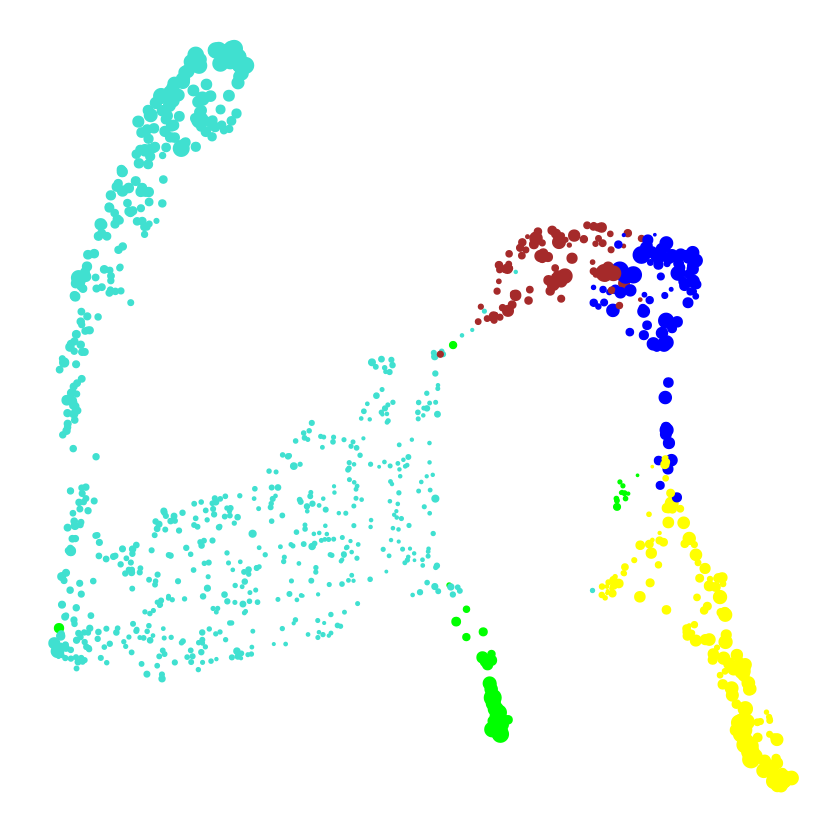

In [23]:
# plot with ggplot
ggplot(umap_df, aes(x=UMAP1, y=-UMAP2)) +
  geom_point(
   color=umap_df$color_human, # color each point by WGCNA module
   size=umap_df$kME*4 # size of each point based on intramodular connectivity
  ) + umap_theme()
#ggsave("umap_gene_TE_hdWGCNA_module_mouse.pdf", width = 5, height = 4)

In [24]:
# link with TE class
umap_df_TE <- umap_df
umap_df_TE$Family <- umap_df$gene

te <- umap_df_TE$Family[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA")]
umap_df_TE$Family[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA")] <- unlist(strsplit(te, split = ".", fixed = T))[seq(1, 3*length(te), by = 3)]
umap_df_TE$Superfamily <- umap_df_TE$gene
umap_df_TE$Superfamily[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA")] <- unlist(strsplit(te, split = ".", fixed = T))[seq(2, 3*length(te), by = 3)]
umap_df_TE$Class <- umap_df_TE$gene
umap_df_TE$Class[grep(umap_df_TE$gene, pattern = "\\.LINE|\\.SINE|\\.LTR|\\.DNA")] <- unlist(strsplit(te, split = ".", fixed = T))[seq(3, 3*length(te), by = 3)]
umap_df_TE$Class <- gsub(pattern = "\\?", replacement = "", umap_df_TE$Class)

umap_df_TE$Superfamily[!(umap_df_TE$Class %in% c("LINE","SINE","LTR","DNA","Retroposon"))] <- "Gene"
umap_df_TE$Class[!(umap_df_TE$Class %in% c("LINE","SINE","LTR","DNA","Retroposon"))] <- "Gene"
head(umap_df_TE)
table(umap_df_TE$Class)

,UMAP1,UMAP2,gene,module,color,hub,kME,color_human,Family,Superfamily,Class
,<dbl>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>
Sox17,4.4712624,-3.510709,Sox17,yellow,yellow,other,0.4394785,brown,Sox17,Gene,Gene
Prex2,4.0878571,-2.689752,Prex2,yellow,yellow,other,0.3384251,brown,Prex2,Gene,Gene
Ptpn18,8.7843069,2.265442,Ptpn18,blue,blue,other,0.5141067,yellow,Ptpn18,Gene,Gene
Neurl3,9.7156404,3.633427,Neurl3,blue,blue,other,0.6751224,yellow,Neurl3,Gene,Gene
Cavin2,7.4600834,-3.472837,Cavin2,brown,brown,hub,0.8898714,blue,Cavin2,Gene,Gene
Myo1b,0.5249946,-1.659945,Myo1b,turquoise,turquoise,other,0.1713813,turquoise,Myo1b,Gene,Gene



 DNA Gene LINE  LTR SINE 
 121  380  136  405   37 

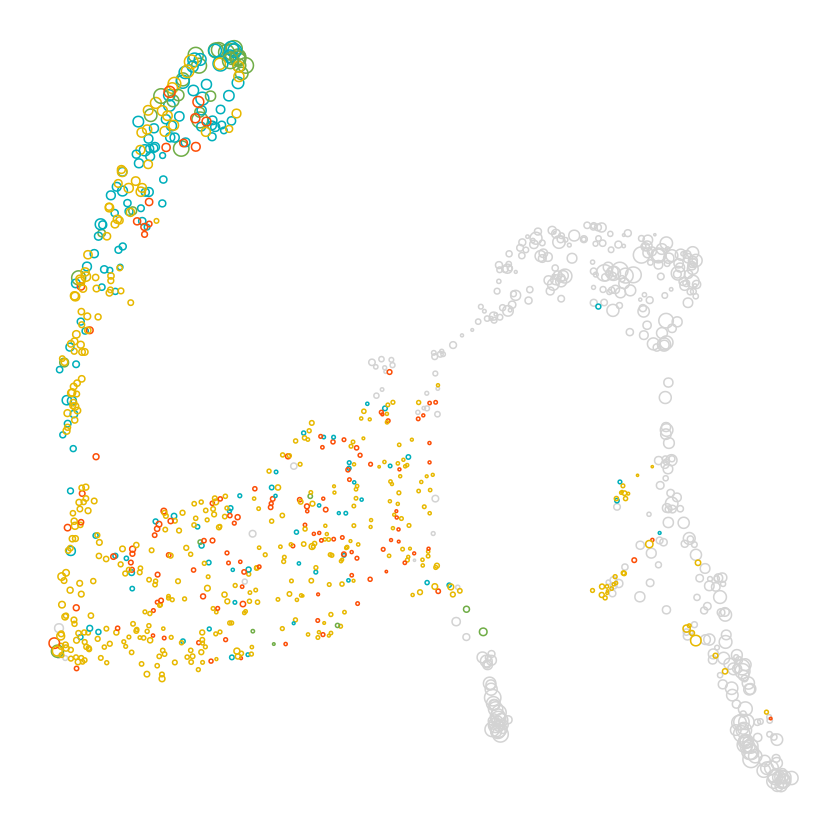

In [25]:
# plot with ggplot with manual color
ggplot(umap_df_TE, aes(x=UMAP1, y=-UMAP2, color=Class)) +
  geom_point(size=umap_df_TE$kME*4, shape=1) + theme(legend.position = "none") + scale_color_manual(values = c("#FC4E07", "lightgrey", "#00AFBB", "#E7B800", "#70AD47")) + umap_theme()
ggsave("figure/umap_gene_TE_hdWGCNA_mouse.pdf", width = 5, height = 4)


Attaching package: ‘ggpubr’


The following object is masked from ‘package:cowplot’:

    get_legend




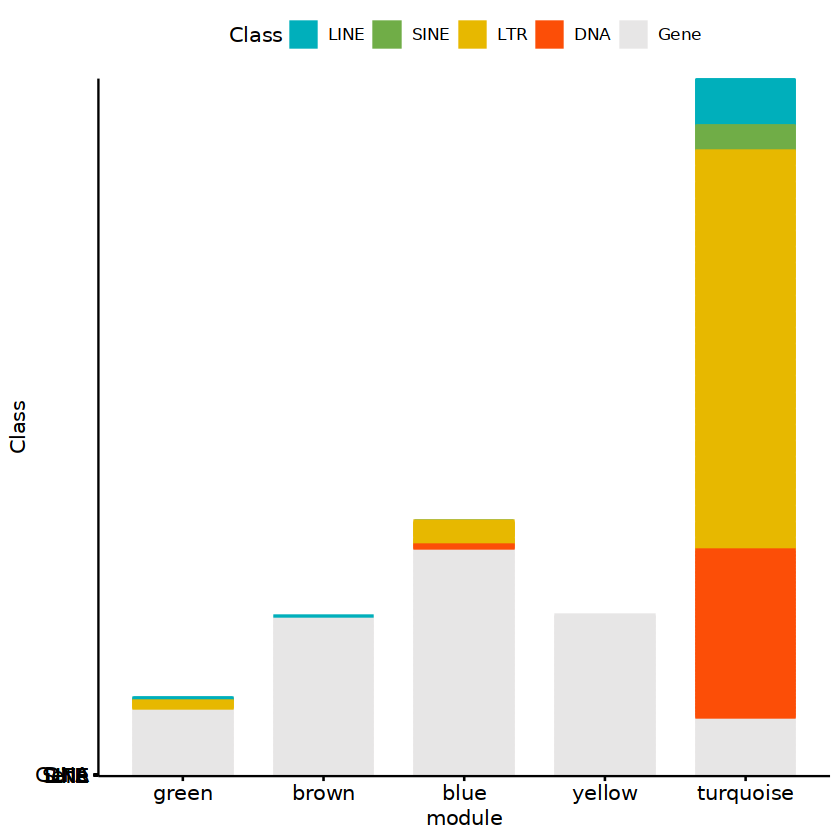

In [26]:
# plot the feature composition in each module
library(ggpubr)
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07", "#E7E6E6")
umap_df_TE$Class <- factor(umap_df_TE$Class, levels = c('LINE','SINE','LTR','DNA','Gene'))
umap_df_TE$module <- factor(umap_df_TE$module, levels = c('green','brown','blue','yellow','turquoise'))
ggbarplot(umap_df_TE, "module", "Class", fill = "Class", color = "Class", palette = class_color)
ggsave("figure/class_distribution_module_mouse.pdf", width = 5, height = 5)

In [27]:
# save the gene umap data
write.csv(umap_df_TE, "meta/umap_df_TE_mouse.csv")


 DNA LINE  LTR SINE 
 118  131  375   35 

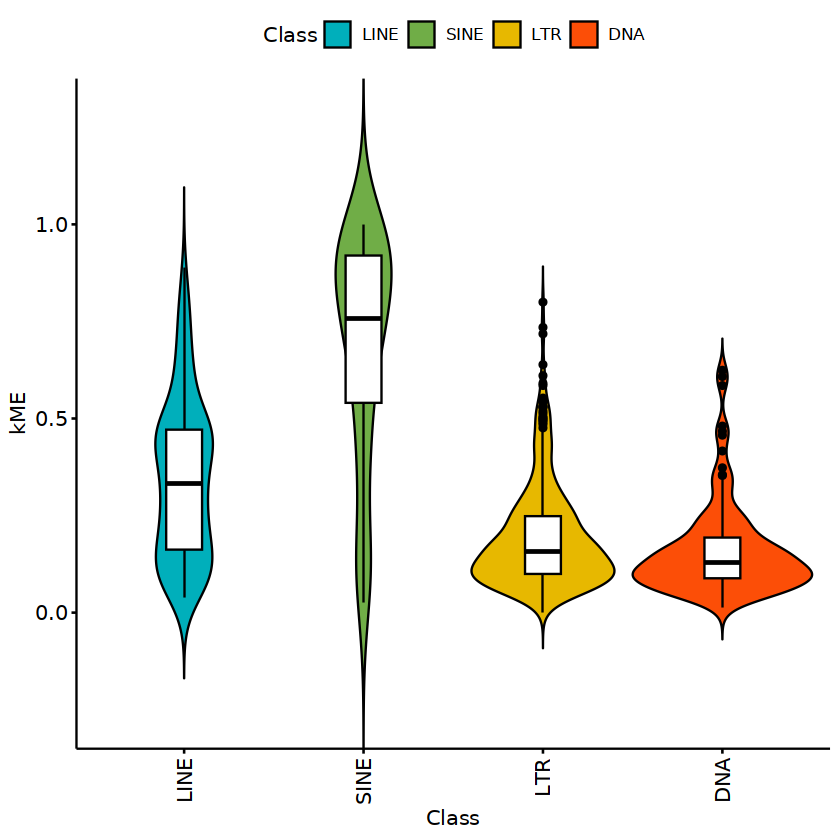

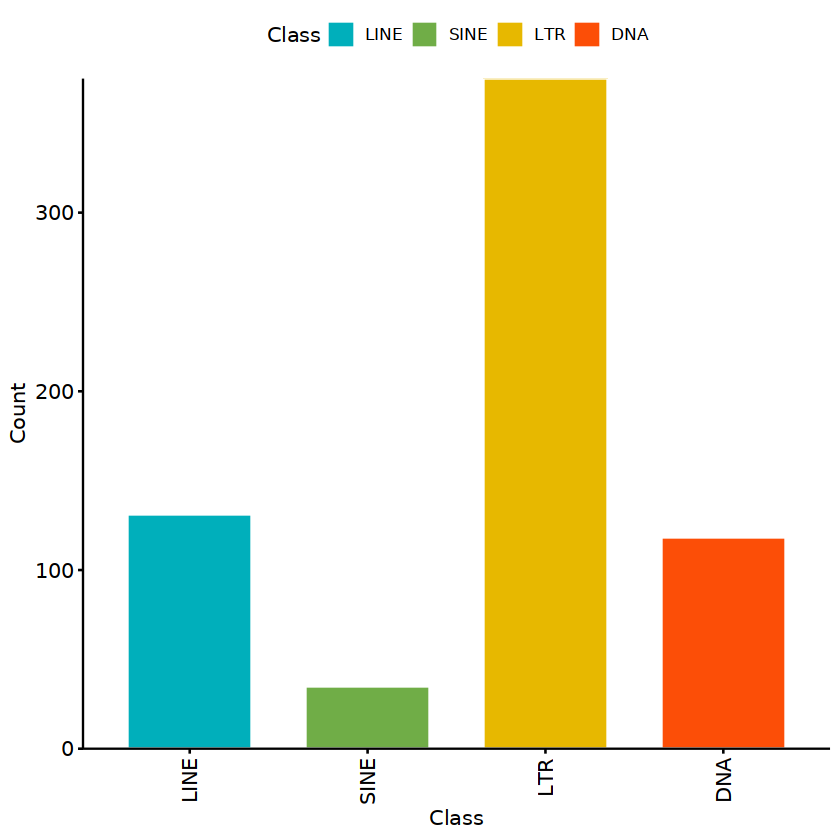

In [28]:
# plot TE composition and kME in HME5
te_module_mm10 <- read.csv("meta/umap_df_TE_mouse.csv", row.names = 1)
te_module_mm10 <- te_module_mm10[te_module_mm10$module == "turquoise", ]
te_module_mm10 <- te_module_mm10[grep(te_module_mm10$gene, pattern = "\\.DNA|\\.SINE|\\.LINE|\\.LTR"), ]
table(te_module_mm10$Class)
te_module_mm10$Class <- factor(te_module_mm10$Class, levels = c("LINE","SINE","LTR","DNA"))
class_color <- c("#00AFBB", "#70AD47", "#E7B800", "#FC4E07")

ggviolin(te_module_mm10, x = "Class", y = "kME",
          fill = "Class",
          palette = class_color,
          sort.val = "none",
          add = "boxplot", add.params = list(fill = "white"),
          x.text.angle = 90
          ) + scale_y_continuous(expand = c(0, 0))
write.csv(te_module_mm10, "meta/te_module_mm10.csv")
ggsave("figure/class_kME_mouse.pdf", width = 4, height = 5)

module_class_mm10 <- data.frame(table(te_module_mm10$Class))
colnames(module_class_mm10) <- c("Class", "Count")
ggbarplot(module_class_mm10, x = "Class", y = "Count",
          fill = "Class",
          color = "white",
          palette = class_color,
          sort.val = "none",
          x.text.angle = 90
          ) + scale_y_continuous(expand = c(0, 0))
ggsave("figure/class_count_mouse.pdf", width = 4, height = 5)

Selecting by kME_yellow
Selecting by kME_blue
Selecting by kME_brown
Selecting by kME_turquoise
Selecting by kME_green


[1] "hub labels"
 [1] "Hey1"             "Gja4"             "Sat1"             "Spi1"            
 [5] "Coro1a"           "Myb"              "Gja5"             "Serpinf1"        
 [9] "Tmem100"          "B1-Mus2.Alu.SINE" "B3.B2.SINE"       "ID-B1.B4.SINE"   
[13] "Cks1b"            "Pclaf"            "Birc5"           
NULL
 [1] "Hey1"             "Gja4"             "Sat1"             "Spi1"            
 [5] "Coro1a"           "Myb"              "Gja5"             "Serpinf1"        
 [9] "Tmem100"          "B1-Mus2.Alu.SINE" "B3.B2.SINE"       "ID-B1.B4.SINE"   
[13] "Cks1b"            "Pclaf"            "Birc5"           
[1] 53950     3
[1] 0 4


Warning message:
“There were 2 warnings in `mutate()`.
The first warning was:
ℹ In argument: `value = scale01(value)`.
Caused by warning in `min()`:
! no non-missing arguments to min; returning Inf
ℹ Run `dplyr::last_dplyr_warnings()` to see the 1 remaining warning.”


[1] "making net"
# A tibble: 0 × 5
# Groups:   color [0]
# ℹ 5 variables: Var1 <fct>, Var2 <fct>, value <dbl>, color <chr>,
#   color_alpha <lgl>
       gene_name    module     color  kME_yellow   kME_blue    kME_grey
Sox17      Sox17    yellow    yellow  0.47078579 -0.2271173  0.21627634
Prex2      Prex2    yellow    yellow  0.41014524 -0.2067991  0.06764358
Ptpn18    Ptpn18      blue      blue -0.06073708  0.4991963 -0.17241521
Neurl3    Neurl3      blue      blue -0.13980847  0.6183038 -0.20257936
Myo1b      Myo1b turquoise turquoise  0.27164764 -0.2344001  0.32101431
Fn1          Fn1     brown     brown  0.40344758  0.1185619  0.11215026
         kME_brown kME_turquoise   kME_green     UMAP1     UMAP2   hub
Sox17   0.19362846    0.10814033 -0.19235514 4.4712624 -3.510709 other
Prex2   0.19479540    0.22744669 -0.13173478 4.0878571 -2.689752 other
Ptpn18  0.22249264    0.01300985 -0.17023195 8.7843069  2.265442 other
Neurl3  0.26652129    0.07337914 -0.17231022 9.7156404  3.633427 o

Warning message in matrix(offset, nrow = 4L, ncol = ncol(x)):
“non-empty data for zero-extent matrix”


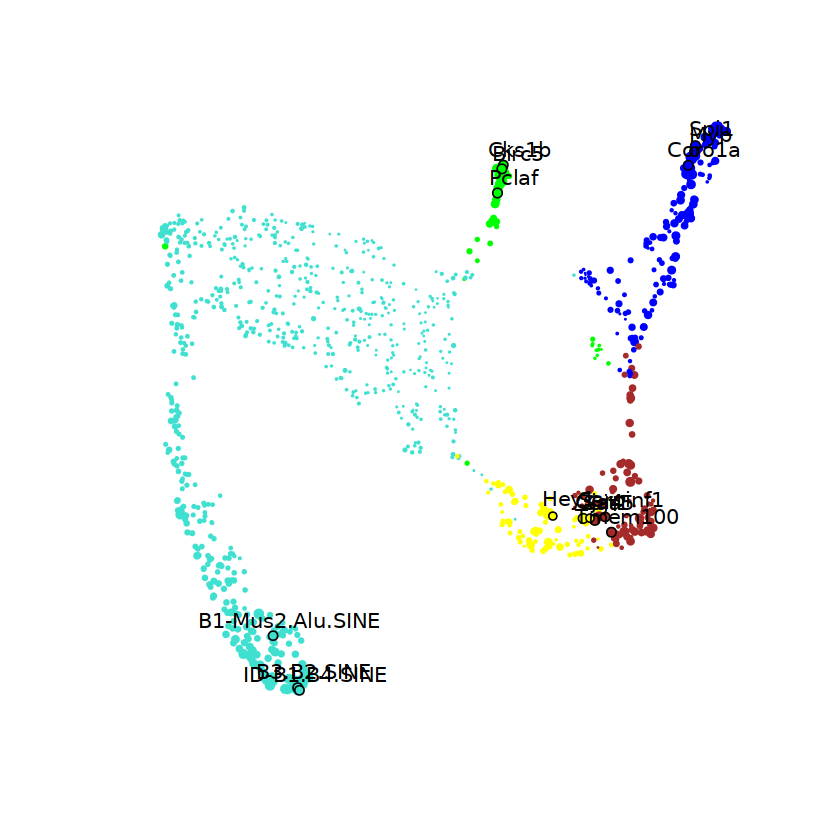

In [29]:
# plot module gene umap
ModuleUMAPPlot(
  sample,
  edge.alpha=0.25,
  sample_edges=TRUE,
  edge_prop=FALSE, # proportion of edges to sample (20% here)
  label_hubs=3 ,# how many hub genes to plot per module?
  keep_grey_edges=FALSE
)

In [30]:
# save the object and export module genes
saveRDS(sample, file = "sample_mouse_hdWGCNA.rds")
write.csv(sample@misc$EHT$wgcna_modules, "meta/module_hdWGCNA_mouse.csv")

In [31]:
# merge the turquoise module of human and mouse
te_module_hg38 <- read.csv("meta/te_module_hg38.csv", row.names = 1)
te_module_mm10 <- read.csv("meta/te_module_mm10.csv", row.names = 1)

te_module_merged <- merge(te_module_hg38, te_module_mm10, by.x = "gene", by.y = "gene", sort = F)
te_module_merged$kME_merged <- te_module_merged$kME.x + te_module_merged$kME.y
te_module_merged <- te_module_merged[order(te_module_merged$kME_merged, decreasing = T), ]
te_module_merged <- te_module_merged[, c("gene","module.x", "hub.x", "kME.x", "module.y", "hub.y", "kME.y", "Family.y", "Superfamily.y", "Class.y", "kME_merged")]
head(te_module_merged)
write.csv(te_module_merged, "meta/te_module_turquoise_common.csv")

,gene,module.x,hub.x,kME.x,module.y,hub.y,kME.y,Family.y,Superfamily.y,Class.y,kME_merged
,<chr>,<chr>,<chr>,<dbl>,<chr>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
194,MIR.MIR.SINE,turquoise,other,0.9005391,turquoise,other,0.7508820,MIR,MIR,SINE,1.651421
113,L2a.L2.LINE,turquoise,hub,0.9682664,turquoise,other,0.6719076,L2a,L2,LINE,1.640174
196,MIRb.MIR.SINE,turquoise,other,0.8861378,turquoise,other,0.7276142,MIRb,MIR,SINE,1.613752
52,L1M5.L1.LINE,turquoise,other,0.8987281,turquoise,other,0.6994623,L1M5,L1,LINE,1.598190
47,L1M4.L1.LINE,turquoise,other,0.7645485,turquoise,other,0.7273280,L1M4,L1,LINE,1.491876
112,L2.L2.LINE,turquoise,other,0.8701052,turquoise,other,0.5710461,L2,L2,LINE,1.441151


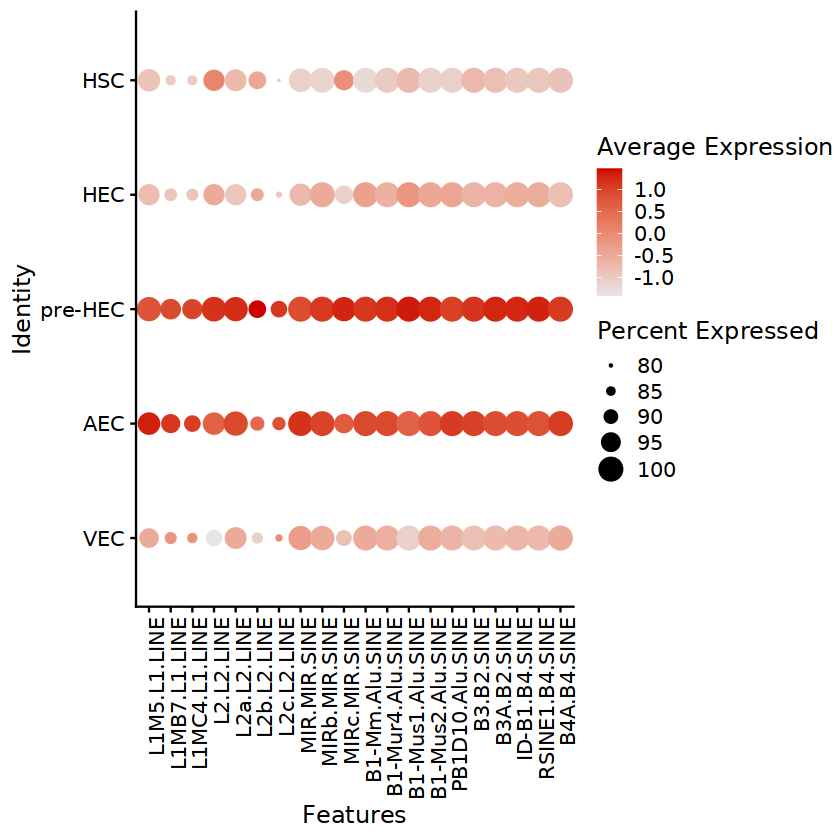

In [32]:
# plot common and specific TE expression
TE_common <- c('L1M5.L1.LINE','L1MB7.L1.LINE','L1MC4.L1.LINE','L2.L2.LINE','L2a.L2.LINE','L2b.L2.LINE','L2c.L2.LINE','MIR.MIR.SINE','MIRb.MIR.SINE','MIRc.MIR.SINE')
TE_mouse_specific <- c('B1-Mm.Alu.SINE','B1-Mur4.Alu.SINE','B1-Mus1.Alu.SINE','B1-Mus2.Alu.SINE','PB1D10.Alu.SINE','B3.B2.SINE','B3A.B2.SINE','ID-B1.B4.SINE','RSINE1.B4.SINE','B4A.B4.SINE')
DotPlot(sample_score, features = c(TE_common, TE_mouse_specific), cols=c("grey90","red3"), group.by="celltype") + theme(axis.text.x=element_text(angle=90, hjust=1))
ggsave("figure/module_turquoise_TE_expression_mm10.pdf", width = 11, height = 3.5)

In [33]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.5 LTS

Matrix products: default
BLAS/LAPACK: /root/miniconda3/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=C.UTF-8    LC_NUMERIC=C        LC_TIME=C          
 [4] LC_COLLATE=C        LC_MONETARY=C       LC_MESSAGES=C      
 [7] LC_PAPER=C          LC_NAME=C           LC_ADDRESS=C       
[10] LC_TELEPHONE=C      LC_MEASUREMENT=C    LC_IDENTIFICATION=C

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] ggpubr_0.6.0          hdWGCNA_0.2.16        WGCNA_1.72-1         
 [4] fastcluster_1.2.3     dynamicTreeCut_1.63-1 igraph_1.4.2         
 [7] devtools_2.4.5        usethis_2.1.6         patchwork_1.1.2      
[10] cowplot_1.1.1         lubridate_1.9.2       forcats_1.0.0        
[13] stringr_1.5.0         dplyr_1.1.1           purrr_1.0.1          
[16] readr_2.1.4           tidyr_1.3.0           tibble_3.2.0 